In [1]:
import open3d as o3d
import numpy as np
import math
import glob, os, re
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import itertools
from pyvis.network import Network
from collections import deque
"""ArithmeticError
aaa
"""

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# 全pcdをロード，インデックスとラベルを対応
# 対象フォルダのパスを指定
folder_path = "/home/aichi2204/Documents/bkl2go/20240412-library2/minimini_1/2"
#'/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_croped_mini_1/tmp'  # ここを対象フォルダのパスに置き換えてください
# パターンにマッチするファイルをすべて取得
file_pattern = os.path.join(folder_path, '[0-9]*.pcd')

file_paths = glob.glob(file_pattern)
pattern = r"/(\d+)\.pcd"
pcd = o3d.io.read_point_cloud(file_paths[0])
l = int(re.search(pattern, file_paths[0]).group(1))
pcd_label = [l] * len(pcd.points)
# pcd_idx = np.array([i for i in range(len(pcd.points))])

for i in range(1, len(file_paths)):
    pcd_tmp  = o3d.io.read_point_cloud(file_paths[i])
    l = int(re.search(pattern, file_paths[i]).group(1))

    pcd += pcd_tmp
    pcd_label += [l] * len(pcd_tmp.points)

pcd_label = np.array(pcd_label)
pcd_idx = np.array([i for i in range(len(pcd.points))])

pcd_tree = o3d.geometry.KDTreeFlann(pcd)

In [3]:
# ノイズを振り分け
th_add_noise = 0.02 #以内の最も近いクラスタに追加

pcd_noise = o3d.io.read_point_cloud(os.path.join(folder_path, 'noise.pcd'))
pcd_noise_label = np.full(len(pcd_noise.points),-1)
pcd_noise_idx = np.array([i for i in range(len(pcd_noise.points))])

for noise_idx in pcd_noise_idx:
    k, neighbor_idx, _ = pcd_tree.search_hybrid_vector_3d(pcd_noise.points[noise_idx] ,th_add_noise, 1)
    if k > 0:
        pcd_noise_label[noise_idx] = pcd_label[neighbor_idx]
        

for noise_idx in pcd_noise_idx[pcd_noise_label!= -1]:
    pcd.points.extend(o3d.utility.Vector3dVector(pcd_noise.points[noise_idx].reshape((-1,3))))
    # pcd.colors.extend(o3d.utility.Vector3dVector(pcd_noise.colors[noise_idx].reshape((-1,3))))
    pcd_idx = np.append(pcd_idx, len(pcd_idx))
    pcd_label   = np.append(pcd_label , pcd_noise_label[noise_idx])

pcd_tree = o3d.geometry.KDTreeFlann(pcd)

/tmp/ipykernel_15529/523275044.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pcd_noise_label[noise_idx] = pcd_label[neighbor_idx]


In [5]:
# #ノイズ追加後一旦保存
# #248を調整
# #1022, 1652, 809 を削除
# # pcd_tmp =  pcd.select_by_index(pcd_idx[pcd_label==25])
# for l in np.unique(pcd_label):
#     pcd_tmp =  pcd.select_by_index(pcd_idx[pcd_label==l])
#     o3d.io.write_point_cloud("/home/aichi2204/Documents/bkl2go/20240412-library2/minimini_1/sp/{}.pcd".format(l), pcd_tmp)

In [2]:
# ノイズ追加が終わってるならここから
# 全pcdをロード，インデックスとラベルを対応
# 対象フォルダのパスを指定
folder_path = "/home/aichi2204/Documents/bkl2go/20240412-library2/minimini_1/sp"
#'/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_croped_mini_1/tmp'  # ここを対象フォルダのパスに置き換えてください
# パターンにマッチするファイルをすべて取得
file_pattern = os.path.join(folder_path, '[0-9]*.pcd')

"""
pcd = [p0,p1,...]
pcd_label:[3,3,3,11,11,11,2,...]
pcd_idx:[0,1,2,...]
pcd[i]のラベルがpcd_label[i]

"""
file_paths = glob.glob(file_pattern)
pattern = r"/(\d+)\.pcd"
pcd = o3d.io.read_point_cloud(file_paths[0])
l = int(re.search(pattern, file_paths[0]).group(1))
pcd_label = [l] * len(pcd.points)
# pcd_idx = np.array([i for i in range(len(pcd.points))])

for i in range(1, len(file_paths)):
    pcd_tmp  = o3d.io.read_point_cloud(file_paths[i])
    l = int(re.search(pattern, file_paths[i]).group(1))
    pcd += pcd_tmp
    pcd_label += [l] * len(pcd_tmp.points)
    
pcd_label = np.array(pcd_label)
pcd_idx = np.array([i for i in range(len(pcd.points))])
pcd_tree = o3d.geometry.KDTreeFlann(pcd)

In [3]:
# pcd_a =  pcd.select_by_index(pcd_idx[pcd_label==25])
# pcd_b =  pcd.select_by_index(pcd_idx[pcd_label==898])
# pcd_a.colors = o3d.utility.Vector3dVector(np.ones((len(pcd_b.points), 3)))
# pcd_b_tree = o3d.geometry.KDTreeFlann(pcd_b)

# # pcd_aの点のうち，pcd_bとの最短距離が5cm以下の点を抽出
# radius = 1.0  # 5cm = 0.05m
# points_a = np.asarray(pcd_a.points)
# filtered_indices = []

# for i, point in enumerate(points_a):
#     [k, idx, dist] = pcd_b_tree.search_radius_vector_3d(point, radius)
#     if k > 0:
#         filtered_indices.append(i)

# # フィルタリングした点群を作成
# filtered_points = [points_a[i] for i in filtered_indices]
# filtered_pcd_a = o3d.geometry.PointCloud()
# filtered_pcd_a.points = o3d.utility.Vector3dVector(filtered_points)

# # 結果を保存または表示
# # o3d.io.write_point_cloud("filtered_pcd_a.pcd", filtered_pcd_a)
# o3d.visualization.draw_geometries([filtered_pcd_a])

In [4]:
# クラスタごとの隣接判定
"""
全点で半径探索
探索内に別クラスタの点があったら隣接

"""

th_is_nei = 0.01 # 最近点が以下なら隣接
nei_cl = [np.array([]) for i in np.unique(pcd_label)]
for idx in pcd_idx:
    l = pcd_label[idx]  # idxのラベル取得

    # 個数 近傍点のインデックスリスト、距離
    k, neighbor_idx, _ = pcd_tree.search_radius_vector_3d(pcd.points[idx] ,th_is_nei)
    nei_cl[l] = np.unique(np.concatenate((nei_cl[l], pcd_label[neighbor_idx]))) # idxのラベルに，隣接するラベルを作成

    mask = pcd_label[neighbor_idx] != pcd_label[idx]
    # for mask_idx in np.array(neighbor_idx)[mask]:
    #     pcd.colors[mask_idx] = np.array([0,1,1])
    
    if idx % 1000 == 0:
        print(idx)

# nei_cl_mat[i,j] = True　のときラベルiとjは隣接
nei_cl_mat= np.zeros((len(nei_cl),len(nei_cl)),dtype=bool)
for i in range(len(nei_cl)):
    for j in nei_cl[i]:
        if i != int(j):
            nei_cl_mat[i,int(j)] = True
print(nei_cl_mat)
print(nei_cl_mat.shape)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [5]:
#pca

# データを格納するリスト
data = [[] for l in np.unique(pcd_label)]

# ディレクトリ内のすべてのpcdファイルについてループ
for l in  range(0,2052): #npvv.unique(pcd_label):

    points = np.asarray(pcd.select_by_index(pcd_idx[pcd_label==l]).points)
    mean = np.mean(points, axis=0)
    # 主成分分析の実行
    pca = PCA(n_components=3)
    pca.fit(points)
    
    # 固有値と固有ベクトルの取得
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_.flatten()
    
    # 固有ベクトル方向の取りうる幅
    d = - np.dot(eigenvectors[6:9], mean)
    # データをリストに追加
    data[l] = [l,*mean, *eigenvalues, *eigenvectors,d]

# データフレームの作成
columns = ['label', 'mx','my','mz','r1', 'r2', 'r3'] + [f'pc{i}_{j}' for i in range(1, 4) for j in range(1, 4)]
columns.append("d")
df = pd.DataFrame(data, columns=columns)
df['label'] = df['label'].astype(int)

In [6]:
def calculate_angle_between_vectors(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    cos_theta = dot_product / (norm_a * norm_b)
    theta_rad = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # np.clipで値を[-1, 1]の範囲に収める
    theta_deg = np.degrees(theta_rad)
    # return min(theta_deg,180-theta_deg)
    return theta_deg

def pcd2normal(p):
    points = np.asarray(p.points)
    mean = np.mean(points, axis=0)
    # 主成分分析の実行
    pca = PCA(n_components=3)
    pca.fit(points)

    # 固有値と固有ベクトルの取得
    # eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_.flatten()
    return np.array(eigenvectors[6:])

In [7]:
# np.array(pcd.select_by_index(pcd_idx[pcd_label==l]).points)
# np.array(pcd_l.points)

In [9]:
# 3_2
"""
路面と成るシードクラスタを指定
クラスタ法線とz軸のなす角度が50~140なら無視
シードクラスタと探索クラスタの法線の差が5度未満なら結合

"""

n_ground = np.array([0,0,1])
is_checked = np.zeros(len(nei_cl),dtype=bool)
is_flat = np.zeros(len(nei_cl),dtype=bool)

l_seed_init = 25

queue = deque()
queue.append(l_seed_init)
is_checked[l_seed_init] = True
is_flat[l_seed_init] = True
pcd_ls = []

while len(queue) > 0:
    l_seed = queue.pop()
    # l_seedクラスタの隣接クラスタを順に探索
    for l in np.where(nei_cl_mat[l_seed, :])[0]:
        if is_checked[l]:
            continue
        is_checked[l] = True
        
        # 垂直なら無視(赤)
        n_l = df.loc[df['label'] == l][['pc3_1', 'pc3_2', 'pc3_3']].values.reshape(3)
        theta_deg = calculate_angle_between_vectors(n_l,n_ground)
        if theta_deg >=50 and  theta_deg <= 140:
            pcd_l = pcd.select_by_index(pcd_idx[pcd_label==l])
            pcd_l.colors = o3d.utility.Vector3dVector(
                np.tile(np.array([1,0,0]), (np.sum([pcd_label==l]), 1))
            )
            pcd_ls.append(pcd_l)
            continue

        # 平面なら怪しいので検索
        pcd_seed = pcd.select_by_index(pcd_idx[pcd_label==l_seed])
        pcd_tree_seed = o3d.geometry.KDTreeFlann(pcd_seed)
        pcd_l_selected_idx = np.array([])
        pcd_seed_selected_idx = np.array([])

        for idx in pcd_idx[pcd_label==l]:
            # 50cm 以内の点
            k, neighbor_idx, _ = pcd_tree_seed.search_radius_vector_3d(pcd.points[idx] ,0.5)
            if k == 0:
                continue

            # print(pcd_idx[pcd_label==l_seed][neighbor_idx])

            # シードクラスタのうち、隣接クラスタとの距離が50cm以内のインデックスを追加
            pcd_l_selected_idx = np.unique(
                np.concatenate((pcd_l_selected_idx, pcd_idx[pcd_label==l_seed][neighbor_idx]))
            )
            # 隣接クラスタのうち、シードクラスタとの距離が50cm以内のインデックスを追加
            pcd_seed_selected_idx = np.append(pcd_seed_selected_idx, idx)

        # 隣接クラスタのうちシードクラスタに近い点群
        pcd_l_selected = pcd.select_by_index(pcd_l_selected_idx.astype(int))
        # シードクラスタのうち点群クラスタに近い点群
        pcd_seed_selected = pcd.select_by_index(pcd_seed_selected_idx.astype(int))

        # 主成分分析で法線を決定
        n_l_selected  = pcd2normal(pcd_l_selected)
        n_seed_selected  = pcd2normal(pcd_seed_selected)

        # 法線のナス角度を計算
        theta_deg = calculate_angle_between_vectors(n_l_selected, n_seed_selected)
        print(l_seed, l, theta_deg)
        # 異なる平面
        if theta_deg >= 5 and  theta_deg <= 175:
            pcd_l = pcd.select_by_index(pcd_idx[pcd_label==l])
            pcd_l.colors = o3d.utility.Vector3dVector(
                np.tile(np.array([0,1,0]), (np.sum([pcd_label==l]), 1))
            )
            pcd_ls.append(pcd_l)
        # 同一平面
        else:
            is_flat[l] = True
            queue.append(l)
            pcd_l = pcd.select_by_index(pcd_idx[pcd_label==l])
            pcd_l.colors = o3d.utility.Vector3dVector(
                np.tile(np.array([0,0,1]), (np.sum([pcd_label==l]), 1))
            )
            pcd_ls.append(pcd_l)

#
label_parent = l_seed_init
label_children = np.where(is_flat)[0]
if label_parent in label_children:
    label_children = label_children[label_children != label_parent]

for l in range(len(nei_cl_mat)):
    if l == label_parent:
        nei_cl_mat[l, label_children] = False
    elif l in label_children:
        nei_cl_mat[l,:] = False
    else:
        if np.any(nei_cl_mat[l, label_children]):
            nei_cl_mat[l,label_parent] = True
            nei_cl_mat[label_parent,l] = True
        nei_cl_mat[l, label_children] = False
        
pcd_label[np.isin(pcd_label, label_children)] = label_parent

25 69 179.33619692506124
25 90 179.1405007059014
25 317 179.24519547184408
25 319 179.00493951573915
25 370 0.29374389143311974
25 480 0.990917013273226
25 500 1.1125561112285427
25 502 11.77236325825705
25 614 178.60853368349788
25 664 177.16374942249982
25 696 1.6296860547883905
25 788 9.029876709975756
25 898 1.4335633732826127
25 929 178.42958632450535
25 936 178.93502084177948
25 964 20.07482940091674
25 1065 7.1813641759764035
25 1111 5.8077304847639555
25 1243 5.357702532597662
25 1489 19.259531343812757
25 1508 0.5686839714420133
25 1667 34.963823432321625
25 1788 157.62136213109056
25 1830 152.92799385986788
25 1841 24.01032838695027
25 1849 163.5560779481188
936 1639 163.59541437746637
500 196 0.5182463563477056
500 1466 179.43933366550417
196 403 179.44684517698616
196 686 176.52359799837467
196 890 1.9336070198054822
890 1123 176.60923231921035
686 410 178.71851941940105
410 770 1.8330324705227263
770 858 178.48281471917343
858 1047 3.969086325233478
1047 963 176.2711902163

In [43]:
# np.save('/home/aichi2204/Documents/bkl2go/20240412-library2/minimini_1/25_ground_merged.npy', nei_cl_mat)

In [11]:
np.isin(pcd_label,np.where(nei_cl_mat[25])[0])

array([False, False, False, ..., False, False, False])

In [ ]:
#73, 50, 75

In [13]:
# o3d.io.write_point_cloud("/home/aichi2204/Documents/bkl2go/20240412-library2/minimini_1/sp_25/25_merged.pcd",
#                          pcd.select_by_index(pcd_idx[pcd_label==25]))
o3d.visualization.draw_geometries([
    pcd.select_by_index(
        pcd_idx[np.isin(pcd_label,np.where(nei_cl_mat[25])[0])]
        )
    ])

# for l in np.where(nei_cl_mat[75])[0]:
#     o3d.io.write_point_cloud(
#         "/home/aichi2204/Documents/bkl2go/20240412-library2/minimini_1/sp_75/{}.pcd".format(l),
#         pcd.select_by_index(pcd_idx[pcd_label==l]))


In [115]:
# ラベル l_seed_init の隣接をたどり，平行部を融合 Trueに　is_flat
# flat
# 25, 73, 50, 75,
#73: 105

# n_ground = np.array([0,0,1])
# is_checked = np.zeros(len(nei_cl),dtype=bool)
# is_flat = np.zeros(len(nei_cl),dtype=bool)

# l_seed_init = 25

# queue = deque()
# queue.append(l_seed_init)
# is_checked[l_seed_init] = True
# is_flat[l_seed_init] = True

# while len(queue) > 0:
#     l_seed = queue.pop()

#     # pcd全体の法線で決定
#     n_l_seed = df.loc[df['label'] == l_seed_init ][['pc3_1', 'pc3_2', 'pc3_3']].values.reshape(3)
#     for l in np.where(nei_cl_mat[l_seed, :])[0]:
#         if is_checked[l]:
#             continue

#         is_checked[l] = True
#         n_l = df.loc[df['label'] == l][['pc3_1', 'pc3_2', 'pc3_3']].values.reshape(3)
#         # theta_deg = calculate_angle_between_vectors(n_l,n_ground)
#         theta_deg = calculate_angle_between_vectors(n_l,n_l_seed)
        
#         # if theta_deg >=80 and  theta_deg <= 100:
#         if theta_deg <= 10 or theta_deg >= 170:
#             queue.append(l)
#             is_flat[l] = True



# label_parent = l_seed_init
# label_children = np.where(is_flat)[0]
# if label_parent in label_children:
#     label_children = label_children[label_children != label_parent]

# for l in range(len(nei_cl_mat)):
#     if l == label_parent:
#         nei_cl_mat[l, label_children] = False
#     elif l in label_children:
#         nei_cl_mat[l,:] = False
#     else:
#         if np.any(nei_cl_mat[l, label_children]):
#             nei_cl_mat[l,label_parent] = True
#             nei_cl_mat[label_parent,l] = True
#         nei_cl_mat[l, label_children] = False
        
# pcd_label[np.isin(pcd_label, label_children)] = label_parent


In [14]:
# 修正後の25の隣接クラスタ同士の結合
"""

"""

l_seed_init = 25
th_is_nei = 0.02 # 壁同士の隣接距離
nei_cl = [np.array([]) for i in np.unique(pcd_label)]

wall_label = np.where(nei_cl_mat[l_seed_init, :])[0]

for idx in pcd_idx:
    l = pcd_label[idx]  # idxのラベル取得
    if nei_cl_mat[l_seed_init,l] == False:  #25と隣接してなければ無視
        continue

    k, neighbor_idx, _ = pcd_tree.search_radius_vector_3d(pcd.points[idx] ,th_is_nei)

    wall_label_nei = np.intersect1d(wall_label, pcd_label[neighbor_idx])
    nei_cl[l] = np.unique(np.concatenate((nei_cl[l], wall_label_nei))) # idxのラベルに，隣接するラベルを作成
    
    if idx % 1000 == 0:
        print(idx)

# nei_cl_mat[i,j] = True　のときラベルiとjは隣接
wall_nei_cl_mat= np.zeros((len(nei_cl),len(nei_cl)),dtype=bool)
for i in range(len(nei_cl)):
    for j in nei_cl[i]:
        if i != int(j):
            wall_nei_cl_mat[i,int(j)] = True
print(wall_nei_cl_mat)

2000
27000
28000
29000
30000
33000
38000
41000
42000
43000
47000
92000
95000
96000
102000
103000
104000
105000
108000
115000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
162000
164000
165000
166000
167000
168000
169000
170000
171000
172000
173000
174000
175000
176000
177000
178000
182000
200000
207000
208000
213000
256000
257000
258000
259000
260000
261000
265000
266000
267000
281000
285000
286000
287000
288000
290000
291000
297000
300000
343000
347000
348000
349000
350000
351000
352000
353000
356000
366000
367000
368000
369000
370000
371000
372000
373000
374000
375000
376000
377000
378000
379000
380000
381000
382000
383000
384000
385000
386000
387000
388000
389000
390000
391000
392000
393000
394000
395000
396000
397000
398000
399000
400000
401000
402000
403000
404000
405000
406000
407000
408000
409000
410000
411000
412000
413000


In [47]:
# 25の直接隣接のみ
l_seed_init = 25
for l_seed_nei in np.where(nei_cl_mat[l_seed_init, :])[0]:
    n_l_seed_nei = df.loc[df['label'] == l_seed_nei][['pc3_1', 'pc3_2', 'pc3_3']].values.reshape(3)
    theta_deg = calculate_angle_between_vectors(n_l_seed_nei, n_ground)
    # if not (theta_deg >=60 and  theta_deg <= 120): # 60>=
    #     continue
    
    is_checked = np.zeros(len(nei_cl),dtype=bool)
    is_flat = np.zeros(len(nei_cl),dtype=bool)
    
    queue = deque()
    queue.append(l_seed_nei)
    is_checked[l_seed_nei] = True
    is_flat[l_seed_nei] = True

    while len(queue) > 0:
        l_seed = queue.pop()
        # for l in np.where(nei_cl_mat[l_seed, :])[0]:
        for l in np.where(wall_nei_cl_mat[l_seed, :])[0]:
            if is_checked[l]:
                continue

            is_checked[l] = True
            n_l = df.loc[df['label'] == l][['pc3_1', 'pc3_2', 'pc3_3']].values.reshape(3)
            # theta_deg = calculate_angle_between_vectors(n_l,n_ground)
            theta_deg = calculate_angle_between_vectors(n_l,n_l_seed_nei)
            
            # if theta_deg >=80 and  theta_deg <= 100:
            if theta_deg <= 10 or theta_deg >= 170:
                queue.append(l)
                is_flat[l] = True

    label_parent = l_seed_nei
    label_children = np.where(is_flat)[0]
    if label_parent in label_children:
        label_children = label_children[label_children != label_parent]

    # for l in range(len(nei_cl_mat)):
    #     if l == label_parent:
    #         nei_cl_mat[l, label_children] = False
    #     elif l in label_children:
    #         nei_cl_mat[l,:] = False
    #     else:
    #         if np.any(nei_cl_mat[l, label_children]):
    #             nei_cl_mat[l,label_parent] = True
    #             nei_cl_mat[label_parent,l] = True
    #         nei_cl_mat[l, label_children] = False
            
    for l in range(len(wall_nei_cl_mat)):
        if l == label_parent:
            wall_nei_cl_mat[l, label_children] = False
        elif l in label_children:
            wall_nei_cl_mat[l,:] = False
        else:
            if np.any(wall_nei_cl_mat[l, label_children]):
                wall_nei_cl_mat[l,label_parent] = True
                wall_nei_cl_mat[label_parent,l] = True
            wall_nei_cl_mat[l, label_children] = False
            

    pcd_label[np.isin(pcd_label, label_children)] = label_parent

In [48]:
np.where(nei_cl_mat[l_seed_init, :])[0]

array([  15,   16,   17,   18,   19,   20,   23,   26,   27,   28,   30,
         31,   32,   36,   42,   45,   48,   49,   52,   53,   55,   56,
         57,   59,   60,   61,   62,   64,   66,   67,   68,   70,   71,
         74,   79,   80,   81,   88,   96,   98,  101,  105,  109,  110,
        112,  114,  116,  119,  130,  131,  132,  134,  137,  142,  154,
        159,  163,  166,  167,  180,  182,  189,  194,  202,  205,  219,
        224,  225,  235,  248,  261,  262,  275,  279,  312,  325,  346,
        352,  354,  355,  361,  367,  376,  391,  395,  417,  438,  444,
        457,  467,  485,  487,  490,  494,  502,  537,  544,  546,  560,
        590,  632,  635,  713,  723,  757,  773,  788,  860,  939,  964,
       1065, 1094, 1111, 1127, 1243, 1269, 1309, 1330, 1357, 1398, 1489,
       1553, 1630, 1639, 1652, 1667, 1678, 1683, 1788, 1830, 1841, 1849,
       1852])

In [49]:
# label_children を label_parent に統合
for l in np.where(nei_cl_mat[l_seed_init, :])[0]:
    o3d.io.write_point_cloud(
        os.path.join(folder_path, 'wall_25-{}.ply'.format(l)), 
        pcd.select_by_index(
            pcd_idx[pcd_label == l]
        )
    )

[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write P

In [23]:
# 統合後の25で
l_seed_init = 25

n_ground = np.array([0,0,1])
is_checked = np.zeros(len(nei_cl),dtype=bool)
is_flat = np.zeros(len(nei_cl),dtype=bool)

queue = deque()
queue.append(l_seed_init)
is_checked[l_seed_init] = True

# n_l_seed_init = df.loc[df['label'] == l_seed][['pc3_1', 'pc3_2', 'pc3_3']].values.reshape(3)

while len(queue) > 0:
    l_seed = queue.pop()
    # n_l_seed = df.loc[df['label'] == l_seed][['pc3_1', 'pc3_2', 'pc3_3']].values.reshape(3)

    for l in np.where(nei_cl_mat[l_seed, :])[0]:
        if is_checked[l]:
            continue

        is_checked[l] = True
        n_l = df.loc[df['label'] == l][['pc3_1', 'pc3_2', 'pc3_3']].values.reshape(3)
        theta_deg = calculate_angle_between_vectors(n_l,n_ground)
        # theta_deg = calculate_angle_between_vectors(n_l,n_l_seed)
        
        if theta_deg >=80 and  theta_deg <= 100:
        # if theta_deg <= 10 or theta_deg >= 170:
            queue.append(l)
            is_flat[l] = True

o3d.io.write_point_cloud(
    os.path.join(folder_path, 'gound1.pcd'), 
    pcd.select_by_index(
        pcd_idx[pcd_label == l_seed_init ]
    )
)

o3d.io.write_point_cloud(
    os.path.join(folder_path, 'gound1_nei_all.pcd'), 
    pcd.select_by_index(
        pcd_idx[np.isin(pcd_label,np.where(is_flat)[0])]
    )
)

# 25の直接隣接のみ
is_flat = np.zeros(len(nei_cl),dtype=bool)
for l in np.where(nei_cl_mat[l_seed_init, :])[0]:
    is_checked[l] = True
    n_l = df.loc[df['label'] == l][['pc3_1', 'pc3_2', 'pc3_3']].values.reshape(3)
    theta_deg = calculate_angle_between_vectors(n_l,n_ground)
    # theta_deg = calculate_angle_between_vectors(n_l,n_l_seed)
    
    if theta_deg >=80 and  theta_deg <= 100:
    # if theta_deg <= 10 or theta_deg >= 170:
        is_flat[l] = True

o3d.io.write_point_cloud(
    os.path.join(folder_path, 'gound1_nei.pcd'), 
    pcd.select_by_index(
        pcd_idx[np.isin(pcd_label,np.where(is_flat)[0])]
    )
)

True

In [24]:
# 25と壁とのエッジ点
edge = []
l_seed_init = 25
pcd.colors = o3d.utility.Vector3dVector(
    np.tile([1,1,1],(len(pcd.points),1)))

# nei_cl = [np.array([]) for i in np.unique(pcd_label)]
for idx in pcd_idx[pcd_label == l_seed_init ]:
    k, neighbor_idx, _ = pcd_tree.search_radius_vector_3d(pcd.points[idx] ,0.02)

    # if len(np.where(pcd_label[neighbor_idx] != 25)[0]) >= 1:
    #     i = np.where(pcd_label[neighbor_idx] != 25)[0][0]
    #     pcd.colors[neighbor_idx[i]] = np.array([1,1,0])
    #     edge.append(neighbor_idx[i])
    for i in np.where(pcd_label[neighbor_idx] != l_seed_init )[0]:
        pcd.colors[neighbor_idx[i]] = np.array([0,1,1])
        edge.append(neighbor_idx[i])
o3d.visualization.draw_geometries([
    pcd.select_by_index(edge)
])
o3d.io.write_point_cloud(
    os.path.join(folder_path, 'all_edge1.ply'), 
    pcd.select_by_index(
        edge
    )
)

True

In [38]:
"""
- 
"""


[581135,
 581129,
 581130,
 581129,
 581130,
 581136,
 581130,
 581129,
 581136,
 581135,
 581130,
 1833767,
 581129,
 581136,
 581129,
 581130,
 581170,
 581169,
 581170,
 581169,
 581168,
 581170,
 581169,
 581176,
 581176,
 581176,
 581176,
 1004160,
 1004160,
 1004160,
 195219,
 446084,
 446083,
 1835531,
 446096,
 446094,
 446108,
 446108,
 446108,
 195222,
 90922,
 90922,
 90923,
 90926,
 90925,
 242064,
 242065,
 242064,
 242069,
 242069,
 242069,
 242073,
 242114,
 242115,
 242111,
 442845,
 442845,
 442847,
 442846,
 442889,
 442887,
 442889,
 442887,
 442887,
 442889,
 90901,
 90929,
 90903,
 90929,
 90903,
 90927,
 1116036,
 1116035,
 593374,
 593375,
 593378,
 103510,
 1116063,
 1116066,
 1830622,
 789690,
 789690,
 789693,
 789693,
 726469,
 726469,
 726470,
 726471,
 726473,
 726476,
 726477,
 726478,
 726479,
 726480,
 726478,
 726481,
 726481,
 195253,
 195253,
 195253,
 195253,
 631128,
 631129,
 631131,
 631128,
 631129,
 631131,
 284184,
 284185,
 284184,
 284185,
 2

In [65]:
import open3d as o3d
import numpy as np
import alphashape
import matplotlib.pyplot as plt

# PCDファイルを読み込む
pcd = o3d.io.read_point_cloud("/home/aichi2204/cloud2mesh_tool/src/c++/region_growing/data/tmp_10/0.pcd")

# 点群データをNumPy配列に変換
points = np.asarray(pcd.points)

# XY平面にプロットするために、z座標を無視
xy_points = points[:, :2]  # XY座標のみ取得

"""
ダウンサンプリング x[m]
店の最短距離 : x[m]
ボール直径: 2x[m]
50mm = 1/(2*0.05) = 10
100m = 1/(2*0.1) = 5
"""

'\nダウンサンプリング x[m]\n店の最短距離 : x[m]\nボール直径: 2x[m]\n50mm = 1/(2*0.05) = 10\n100m = 1/(2*0.1) = 5\n'

done


AttributeError: 'MultiPolygon' object has no attribute 'exterior'

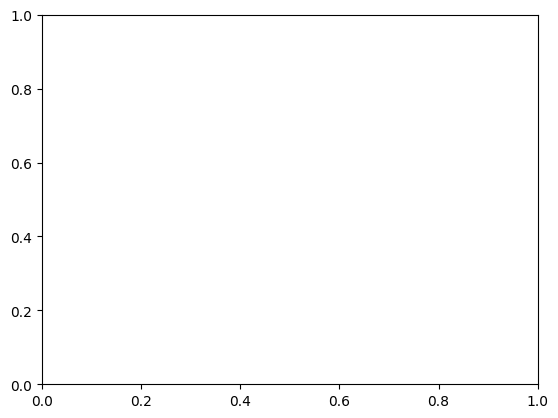

In [64]:
# アルファシェイプの実行
alpha = 1/(2*0.01) # 適切なalpha値を調整してください
alpha_shape = alphashape.alphashape(xy_points, alpha)
print("done")
# プロット
fig, ax = plt.subplots()
# ax.scatter(xy_points[:, 0], xy_points[:, 1], color='blue', label='Points')

# アルファシェイプのプロット
if alpha_shape is not None:
    ax.plot(*alpha_shape.exterior.xy, color='red', label='Alpha Shape')

plt.title("Alpha Shape on XY plane")
plt.legend()
plt.show()